# EEG-Based Visual Recognition: Classification to Semantic Retrieval
## Final Project Submission - Group 10

**Team Members:** Madhavi Gulavani, Praneeth Chaitanya Jonnavithula, Prithiraj Bhuyan

**Course:** 11-685 Introduction to Deep Learning (Fall 2025)

---

This notebook implements:
1. **Task 1**: EEG-based image classification with advanced architectures
2. **Task 2A**: Image-Caption retrieval using pretrained CLIP
3. **Task 2B**: EEG-Caption retrieval with various CLIP fine-tuning strategies
4. **Comprehensive Evaluation**: All required metrics and analyses

## Setup and Imports

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import wandb
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
# Set Seed
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

set_seed(42)

# Check Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {DEVICE}")

Using device: cuda
GPU: Tesla V100-SXM2-32GB


In [ ]:
# Login to WandB
wandb.login(key="825201e63a02e53435b53a136158ab39815c89a4")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /jet/home/gulavani/.netrc
wandb: Appending key for api.wandb.ai to your netrc file: /jet/home/gulavani/.netrc


wandb: Currently logged in as: mgulavan (mgulavan-carnegie-mellon-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Data Loading and Preprocessing

In [ ]:
BIDS_ROOT = '/ocean/projects/cis250019p/gandotra/11785-gp-eeg/ds005589'
IMAGE_DIR = '/ocean/projects/cis250019p/gandotra/11785-gp-eeg/images'
CAPTIONS_FILE = '/ocean/projects/cis250019p/gandotra/11785-gp-eeg/captions.txt'
ALL_SUBJECTS = ['sub-02', 'sub-03', 'sub-05', 'sub-09', 'sub-14', 'sub-15', 
                'sub-17', 'sub-19', 'sub-20', 'sub-23', 'sub-24', 'sub-28', 'sub-29']

class EEG_Paper_Replication_Dataset(Dataset):
    def __init__(self, bids_root, images_dir, captions_path, 
                 subject_list, session_list, 
                 clamp_thres=500, stats=None):
        
        self.bids_root = bids_root
        self.images_dir = images_dir
        self.clamp_thres = clamp_thres
        self.trial_metadata = []
        
        # --- Create Subject Mapping ---
        # Map 'sub-02' -> 0, 'sub-03' -> 1, etc.
        # We sort to ensure consistency across Train/Val/Test sets
        self.subject_to_idx = {sub: i for i, sub in enumerate(sorted(list(set(subject_list))))}
        
        # 1. Load Captions Helper
        self.captions_dict = self._load_captions(captions_path)
        self.category_to_idx = {cat: i for i, cat in enumerate(sorted(set(c for c, _ in self.captions_dict.values())))}
        
        # 2. Scan Metadata
        print(f"Scanning metadata for {session_list}...")
        for sub in subject_list:
            for ses in session_list:
                for run in ['01', '02', '03', '04']:
                    session_path = os.path.join(self.bids_root, sub, ses)
                    csv_path = os.path.join(session_path, f"{sub}_{ses}_task-lowSpeed_run-{run}_image.csv")
                    npy_path = os.path.join(session_path, f"{sub}_{ses}_task-lowSpeed_run-{run}_1000Hz.npy")
                    
                    if not (os.path.exists(csv_path) and os.path.exists(npy_path)):
                        continue
                        
                    try:
                        csv_data = pd.read_csv(csv_path)
                        for i, row in csv_data.iterrows():
                            img_base_name = self._get_base_name(row['FilePath'])
                            if not img_base_name: continue
                            
                            category, caption = self.captions_dict.get(img_base_name, (None, None))
                            if not category: continue
                            
                            self.trial_metadata.append({
                                'npy_path': npy_path,
                                'trial_index': i,
                                'label': self.category_to_idx[category],
                                'subject_id': self.subject_to_idx[sub],
                                'image_name': img_base_name,
                                'caption': caption 
                            })
                    except:
                        continue
        
        print(f"Found {len(self.trial_metadata)} trials.")

        # 3. Compute Global Statistics (GFS)
        if stats is None:
            print("Computing Global Statistics (this takes ~1 min)...")
            self.mean, self.std = self._compute_global_stats()
        else:
            self.mean, self.std = stats

    def _compute_global_stats(self):
        subset_indices = range(0, len(self.trial_metadata), 10)
        sum_x = 0
        sum_sq_x = 0
        count = 0
        
        for i in tqdm(subset_indices, desc="Calculating Stats"):
            meta = self.trial_metadata[i]
            d = np.load(meta['npy_path'])[meta['trial_index']]
            d = np.clip(d, -self.clamp_thres, self.clamp_thres)
            
            sum_x += np.mean(d)
            sum_sq_x += np.mean(d**2)
            count += 1
            
        global_mean = sum_x / count
        global_std = np.sqrt((sum_sq_x / count) - (global_mean**2))
        return float(global_mean), float(global_std)

    def get_stats(self): return self.mean, self.std

    def _load_captions(self, path):
        d = {}
        with open(path, 'r') as f:
            next(f)
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) >= 4: d[parts[2]] = (parts[1], parts[3])
        return d

    def _get_base_name(self, p):
        try:
            bn = os.path.splitext(os.path.basename(str(p).replace('\\', '/')))[0]
            if bn.endswith('_resized'): return bn[:-8]
            return bn
        except: return None

    def _get_image_path(self, image_name):
        """Find full path to image file"""
        for ext in ['.jpg', '.jpeg', '.png', '.JPEG', '.JPG']:
            path = os.path.join(self.images_dir, image_name + ext)
            if os.path.exists(path):
                return path
        return None  # Image not found

    def __len__(self): return len(self.trial_metadata)

    def __getitem__(self, idx):
        meta = self.trial_metadata[idx]
        eeg_data = np.load(meta['npy_path'])[meta['trial_index']]
        eeg_data = np.clip(eeg_data, -self.clamp_thres, self.clamp_thres)
        # Global Feature Standardization
        eeg_data = (eeg_data - self.mean) / (self.std + 1e-6)

        img_path = self._get_image_path(meta['image_name'])
        caption = meta['caption']
        
        return {
            'eeg': torch.tensor(eeg_data, dtype=torch.float32),
            'label': torch.tensor(meta['label'], dtype=torch.long),
            'subject_id': torch.tensor(meta['subject_id'], dtype=torch.long),
            'image_path': img_path,  # for Task 2
            'caption': caption  # for Task 2
        }

In [ ]:
# ============================================================================
# CREATE DATASETS AND DATALOADERS
# ============================================================================
# 1. Create Transforms (Standard ImageNet stats)
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 2. Instantiate Training Dataset
print("--- Init Train ---")
train_ds = EEG_Paper_Replication_Dataset(
    bids_root=BIDS_ROOT, 
    images_dir=IMAGE_DIR, 
    captions_path=CAPTIONS_FILE, 
    subject_list=ALL_SUBJECTS, 
    session_list=['ses-01', 'ses-02', 'ses-03'], 
    clamp_thres=500
)
# Save stats to use for validation (Prevent data leakage)
stats = train_ds.get_stats()

# 3. Instantiate Validation Dataset
print("\n--- Init Validation ---")
val_ds = EEG_Paper_Replication_Dataset(
    bids_root=BIDS_ROOT, 
    images_dir=IMAGE_DIR, 
    captions_path=CAPTIONS_FILE, 
    subject_list=ALL_SUBJECTS, 
    session_list=['ses-04'], 
    clamp_thres=500,
    stats=stats # <--- IMPORTANT: Use training stats
)

# 4. Define The Loaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

print(f"\n✅ Loaders Ready: {len(train_loader)} training batches, {len(val_loader)} validation batches.")


DATA LOADING

Creating TRAINING dataset...
Loading data from 13 subjects, 3 sessions...
Found 15600 valid trials
Computing normalization statistics...
Found 15600 valid trials
Computing normalization statistics...

Creating VALIDATION dataset...
Loading data from 13 subjects, 1 sessions...

Creating VALIDATION dataset...
Loading data from 13 subjects, 1 sessions...
Found 5200 valid trials

Creating TEST dataset...
Loading data from 13 subjects, 1 sessions...
Found 5200 valid trials

Creating TEST dataset...
Loading data from 13 subjects, 1 sessions...
Found 5200 valid trials

Train: 15600, Val: 5200, Test: 5200

✓ Train loader: 488 batches
✓ Val loader: 163 batches
✓ Test loader: 163 batches

✓ Using device: cuda
Found 5200 valid trials

Train: 15600, Val: 5200, Test: 5200

✓ Train loader: 488 batches
✓ Val loader: 163 batches
✓ Test loader: 163 batches

✓ Using device: cuda


## Task 1: EEG Classification

### Model Architecture

We implement a multi-head architecture with:
1. **CNN Feature Extractor**: Extracts temporal features from EEG channels
2. **Transformer Backbone**: Models relationships across channels (shared across subjects)
3. **Subject-Specific Heads**: Separate classification heads for each subject

In [ ]:
class EEG_ViT_1D(nn.Module):
    def __init__(self, num_subjects=13, num_classes=20):
        super().__init__()
        
        # --- Hyperparameters ---
        self.patch_size = 50      # 50ms window 
        self.stride = 25          # 50% overlap
        self.embed_dim = 128      # Feature size
        self.num_heads = 4
        self.depth = 2
        
        # --- 1. Tokenizer (The "Patchify" Step) ---
        # Input: (Batch, 122, 500) -> Output: (Batch, 128, ~19)
        self.tokenizer = nn.Sequential(
            nn.Conv1d(122, self.embed_dim, kernel_size=self.patch_size, stride=self.stride, padding=0),
            nn.BatchNorm1d(self.embed_dim),
            nn.LeakyReLU(0.1)
        )
        
        # --- 2. Learnable "Class Token" ---
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.embed_dim))
        
        # --- 3. Positional Embedding ---
        self.pos_embedding = nn.Parameter(torch.randn(1, 32, self.embed_dim) * 0.01)
        
        # --- 4. Transformer Encoder ---
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.embed_dim, 
            nhead=self.num_heads, 
            dim_feedforward=512, 
            dropout=0.5, 
            batch_first=True,
            norm_first=True 
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=self.depth)
        
        # --- 5. Subject-Specific Heads ---
        self.heads = nn.ModuleList([
            nn.Linear(self.embed_dim, num_classes) for _ in range(num_subjects)
        ])

    def forward(self, x, subject_ids):
        # Input comes in as (Batch, 500, 122) -> We need (Batch, 122, 500)
        if x.shape[1] == 500 and x.shape[2] == 122:
            x = x.permute(0, 2, 1)
            
        # Safety Crop (in case data is >500)
        if x.shape[2] > 500:
            x = x[:, :, :500]
            
        # ----------------------------------------
        
        # 1. Tokenize
        x = self.tokenizer(x)     # Output: (Batch, 128, 19)
        x = x.permute(0, 2, 1)    # Output: (Batch, 19, 128) -> (Batch, Seq, Dim)
        
        b, seq_len, _ = x.shape
        
        # 2. Append CLS Token
        cls_tokens = self.cls_token.expand(b, -1, -1) 
        x = torch.cat((cls_tokens, x), dim=1) # (Batch, 20, 128)
        
        # 3. Add Positional Embedding
        x = x + self.pos_embedding[:, :seq_len + 1, :]
        
        # 4. Transformer Attention
        x = self.transformer(x)
        
        # 5. Extract ONLY the CLS token output
        cls_output = x[:, 0, :]   # (Batch, 128)
        
        # 6. Subject Routing
        logits = torch.zeros(x.shape[0], 20).to(x.device)
        unique_subs = torch.unique(subject_ids)
        
        for sub in unique_subs:
            mask = (subject_ids == sub)
            logits[mask] = self.heads[sub.long()](cls_output[mask])
            
        return logits

In [ ]:
RESUME_TRAINING = False
CHECKPOINT_PATH = "best_model_vit_1d.pth"
TOTAL_EPOCHS = 100

wandb.init(
    project="eeg-classification",
    name="vit-1d-run",
    config={
        "architecture": "ViT-1D",
        "dataset": "GFS",
        "epochs": TOTAL_EPOCHS,
        "lr": 1e-3
    }
)

model = EEG_ViT_1D(num_subjects=13, num_classes=20).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()

print(f"Model Parameters: {sum(p.numel() for p in model.parameters()):,}")

start_epoch = 1
best_val_acc = 0.0

if RESUME_TRAINING and os.path.exists(CHECKPOINT_PATH):
    print(f"🔄 Attempting to resume from {CHECKPOINT_PATH}...")
    try:
        checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
        
        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
            if 'optimizer_state_dict' in checkpoint:
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            start_epoch = checkpoint.get('epoch', 0) + 1
            best_val_acc = checkpoint.get('val_acc', 0.0)
            print(f"✅ Resuming from Epoch {start_epoch} with Best Acc {best_val_acc:.2f}%")
        else:
            model.load_state_dict(checkpoint)
            print(f"⚠️ Only weights found. Resuming from Epoch 1.")
            
    except Exception as e:
        print(f"❌ Error loading checkpoint: {e}. Starting fresh.")
else:
    print("🆕 Starting a fresh training run.")

print(f"\n🚀 Training from Epoch {start_epoch} to {TOTAL_EPOCHS}...")

for epoch in range(start_epoch, TOTAL_EPOCHS + 1):
    model.train()
    correct = 0
    total = 0
    
    for batch in tqdm(train_loader, desc=f"Epoch {epoch}", leave=False):
        eeg = batch['eeg'].to(DEVICE)
        label = batch['label'].to(DEVICE)
        sub_id = batch['subject_id'].to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(eeg, sub_id)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        
        _, pred = outputs.max(1)
        correct += pred.eq(label).sum().item()
        total += label.size(0)
        
    train_acc = 100. * correct / total
    
    model.eval()
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch in val_loader:
            eeg = batch['eeg'].to(DEVICE)
            label = batch['label'].to(DEVICE)
            sub_id = batch['subject_id'].to(DEVICE)
            
            outputs = model(eeg, sub_id)
            _, pred = outputs.max(1)
            val_correct += pred.eq(label).sum().item()
            val_total += label.size(0)
            
    val_acc = 100. * val_correct / val_total
    
    print(f"Epoch {epoch:02d}: Train Acc {train_acc:.2f}% | Val Acc {val_acc:.2f}%")
    
    wandb.log({
        "epoch": epoch,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "train_loss": loss.item()
    })
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'train_acc': train_acc
        }, CHECKPOINT_PATH)
        
        wandb.save(CHECKPOINT_PATH) 
        
        print(f"  ✅ Best Model Saved & Uploaded! ({val_acc:.2f}%)")

wandb.finish()

In [ ]:
print("Loading Test Set (Session 5)...")
test_ds = EEG_Paper_Replication_Dataset(
    BIDS_ROOT, IMAGE_DIR, CAPTIONS_FILE, ALL_SUBJECTS, 
    ['ses-05'], # FINAL TEST SET
    stats=stats,
    clamp_thres=500
)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=4)

def evaluate_detailed(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    subject_results = {i: {'correct': 0, 'total': 0} for i in range(len(ALL_SUBJECTS))}
    
    with torch.no_grad():
        for eeg, label, sub_id in tqdm(loader, desc="Testing"):
            eeg, label, sub_id = eeg.to(device), label.to(device), sub_id.to(device)
            
            outputs = model(eeg, sub_id)
            _, preds = outputs.max(1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label.cpu().numpy())
            
            for i in range(len(label)):
                sid = sub_id[i].item()
                is_correct = (preds[i] == label[i]).item()
                subject_results[sid]['total'] += 1
                subject_results[sid]['correct'] += is_correct
                
    return all_labels, all_preds, subject_results

print("Running Final Evaluation...")
y_true, y_pred, sub_metrics = evaluate_detailed(model, test_loader, DEVICE)

overall_acc = accuracy_score(y_true, y_pred) * 100
print(f"\n🏆 Final Test Accuracy: {overall_acc:.2f}%")

sub_accs = []
sub_names = []
for sid, metrics in sub_metrics.items():
    if metrics['total'] > 0:
        acc = (metrics['correct'] / metrics['total']) * 100
        sub_accs.append(acc)
        sub_names.append(ALL_SUBJECTS[sid])
        
plt.figure(figsize=(12, 5))
sns.barplot(x=sub_names, y=sub_accs, palette="viridis")
plt.axhline(y=overall_acc, color='r', linestyle='--', label=f'Avg: {overall_acc:.1f}%')
plt.axhline(y=5.0, color='gray', linestyle='--', label='Random Chance (5%)')
plt.title("Per-Subject Classification Accuracy (Session 5)")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

cat_map = {v: k for k, v in test_ds.category_to_idx.items()}
cat_names = [cat_map[i] for i in range(len(cat_map))]

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(14, 12))
sns.heatmap(cm_norm, annot=False, fmt=".2f", cmap="Blues", xticklabels=cat_names, yticklabels=cat_names)
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

MADHAVI'S CODE

In [ ]:
# ============================================================================
# MODEL SELECTION HELPER FOR TASK 2B
# ============================================================================

def load_task1_encoder(model_type, task1_run_id, device):
    """
    Load the trained encoder from Task 1 for use in Task 2B
    
    Args:
        model_type: "baseline", "cnn", or "multihead"
        task1_run_id: wandb run ID from Task 1 training
        device: torch device
    
    Returns:
        encoder: The trained encoder module
        encoder_dim: Output dimension of encoder
    """
    
    print(f"\n📥 Loading Task 1 encoder ({model_type})...")
    
    # Download checkpoint from wandb
    checkpoint_file = wandb.restore(
        'best_model.pth', 
        run_path=f"{wandb.run.entity}/eeg-visual-recognition/{task1_run_id}"
    )
    checkpoint = torch.load(checkpoint_file.name, map_location=device)
    
    # Create the same model architecture
    if model_type == "baseline":
        model = BaselineEEGClassifier(
            input_dim=122*500,
            hidden_dim=512,
            num_classes=20,
            dropout=0.5
        ).to(device)
        encoder_dim = 256
        
    elif model_type == "cnn":
        model = CNNEEGClassifier(
            num_channels=122,
            num_timepoints=500,
            num_classes=20
        ).to(device)
        encoder_dim = 256
        
    elif model_type == "multihead":
        model = MultiHeadEEGClassifier(
            num_subjects=13,
            num_classes=20,
            backbone_dim=256
        ).to(device)
        encoder_dim = 256
    
    else:
        raise ValueError(f"Unknown model_type: {model_type}")
    
    # Load trained weights
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Extract encoder
    encoder = model.get_encoder()
    
    print(f"✓ Loaded encoder from Task 1")
    print(f"  Epoch: {checkpoint['epoch']}")
    print(f"  Val Accuracy: {checkpoint['val_acc']:.2f}%")
    print(f"  Encoder output dim: {encoder_dim}")
    
    return encoder, encoder_dim

In [11]:
print(f"\n{'='*60}")
print(f"TRAINING COMPLETED")
print(f"{'='*60}")
print(f"Best Validation Accuracy: {results['best_val_acc']:.2f}%")
print(f"Chance Level: {100/20:.2f}%")
print(f"Above Chance: {'✓ YES' if results['best_val_acc'] > 5 else '✗ NO'}")

# # Plot training curves
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# ax1.plot(results['history']['train_loss'])
# ax1.set_title('Training Loss')
# ax1.set_xlabel('Epoch')
# ax1.set_ylabel('Loss')
# ax1.grid(True)

# ax2.plot(results['history']['train_acc'], label='Train')
# ax2.plot(results['history']['val_acc'], label='Val')
# ax2.axhline(y=5, color='r', linestyle='--', label='Chance')
# ax2.set_title('Accuracy')
# ax2.set_xlabel('Epoch')
# ax2.set_ylabel('Accuracy (%)')
# ax2.legend()
# ax2.grid(True)

# plt.tight_layout()
# plt.savefig(f'task1_{MODEL_TYPE}_training_curves.png', dpi=150)
# print(f"\n✓ Training curves saved to: task1_{MODEL_TYPE}_training_curves.png")
plt.show()


TRAINING COMPLETED
Best Validation Accuracy: 9.92%
Chance Level: 5.00%
Above Chance: ✓ YES


In [23]:
# ============================================================================
# TASK 1: EVALUATION
# ============================================================================

def evaluate_task1(model, test_loader, device, use_subject_heads=False):
    """
    Comprehensive evaluation for Task 1
    
    Args:
        model: Trained classifier
        test_loader: Test data loader
        device: torch device
        use_subject_heads: Whether model uses subject-specific heads
    
    Returns:
        Dictionary with all evaluation metrics
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_subjects = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating Task 1"):
            eeg = batch['eeg'].to(device)
            labels = batch['label'].to(device)
            subject_ids = batch['subject_id'].to(device)
            
            if use_subject_heads:
                outputs = model(eeg, subject_ids)
            else:
                outputs = model(eeg)
            
            _, preds = outputs.max(1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_subjects.extend(subject_ids.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_subjects = np.array(all_subjects)
    
    # ========== OVERALL ACCURACY ==========
    overall_acc = 100. * accuracy_score(all_labels, all_preds)
    
    # ========== PER-SUBJECT ACCURACY ==========
    subject_accs = {}
    for sid in np.unique(all_subjects):
        mask = all_subjects == sid
        if mask.any():
            subject_accs[sid] = 100. * accuracy_score(all_labels[mask], all_preds[mask])
    
    # ========== CONFUSION MATRIX ==========
    cm = confusion_matrix(all_labels, all_preds)
    
    # ========== PER-CLASS ACCURACY ==========
    class_accs = {}
    for class_id in range(20):
        mask = all_labels == class_id
        if mask.any():
            class_accs[class_id] = 100. * accuracy_score(all_labels[mask], all_preds[mask])
    
    # ========== PRINT RESULTS ==========
    print(f"\n{'='*60}")
    print(f"TASK 1: CLASSIFICATION RESULTS")
    print(f"{'='*60}")
    
    print(f"\n📊 Overall Performance:")
    print(f"   Test Accuracy: {overall_acc:.2f}%")
    print(f"   Chance Level: {100/20:.2f}%")
    print(f"   Above Chance: {'✓ YES' if overall_acc > 5 else '✗ NO'}")
    
    print(f"\n👥 Per-Subject Accuracy:")
    for sid, acc in sorted(subject_accs.items()):
        print(f"   Subject {sid:2d}: {acc:5.2f}%")
    
    avg_subject_acc = np.mean(list(subject_accs.values()))
    std_subject_acc = np.std(list(subject_accs.values()))
    print(f"\n   Mean ± Std: {avg_subject_acc:.2f}% ± {std_subject_acc:.2f}%")
    
    print(f"\n📁 Per-Class Accuracy:")
    class_names = [
        'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
        'bus', 'car', 'cat', 'chair', 'cow',
        'diningtable', 'dog', 'horse', 'motorbike', 'person',
        'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
    ]
    
    # Sort by accuracy
    sorted_classes = sorted(class_accs.items(), key=lambda x: x[1], reverse=True)
    
    print("\n   Top 5 Classes:")
    for class_id, acc in sorted_classes[:5]:
        print(f"   {class_names[class_id]:15s}: {acc:5.2f}%")
    
    print("\n   Bottom 5 Classes:")
    for class_id, acc in sorted_classes[-5:]:
        print(f"   {class_names[class_id]:15s}: {acc:5.2f}%")
    
    # ========== CONFUSION MATRIX VISUALIZATION ==========
    print(f"\n📈 Confusion Matrix Summary:")
    print(f"   Diagonal (correct): {np.diag(cm).sum()}")
    print(f"   Off-diagonal (errors): {cm.sum() - np.diag(cm).sum()}")
    
    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix (Accuracy: {overall_acc:.2f}%)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'viz/task1_confusion_matrix_{MODEL_TYPE}.png', dpi=150, bbox_inches='tight')
    print(f"\n✓ Confusion matrix saved to: viz/task1_confusion_matrix_{MODEL_TYPE}.png")
    
    return {
        'overall_acc': overall_acc,
        'subject_accs': subject_accs,
        'class_accs': class_accs,
        'confusion_matrix': cm,
        'predictions': all_preds,
        'labels': all_labels,
        'subjects': all_subjects
    }


LOADING BEST MODEL FOR EVALUATION

LOADING BEST MODEL
✓ Loaded model from epoch 21
  Validation accuracy: 9.63%


Evaluating Task 1: 100%|████████████████████████████████████████████████████████████████████████████| 163/163 [00:21<00:00,  7.42it/s]



TASK 1: CLASSIFICATION RESULTS

📊 Overall Performance:
   Test Accuracy: 9.54%
   Chance Level: 5.00%
   Above Chance: ✓ YES

👥 Per-Subject Accuracy:
   Subject  0:  6.75%
   Subject  1:  7.25%
   Subject  2: 11.25%
   Subject  3: 11.25%
   Subject  4:  8.50%
   Subject  5:  7.25%
   Subject  6: 11.00%
   Subject  7:  7.00%
   Subject  8:  9.25%
   Subject  9: 14.00%
   Subject 10:  9.25%
   Subject 11: 11.50%
   Subject 12:  9.75%

   Mean ± Std: 9.54% ± 2.11%

📁 Per-Class Accuracy:

   Top 5 Classes:
   pottedplant    : 20.38%
   boat           : 19.23%
   chair          : 17.31%
   horse          : 15.38%
   dog            : 13.85%

   Bottom 5 Classes:
   sheep          :  5.00%
   cow            :  4.23%
   motorbike      :  3.85%
   bird           :  3.46%
   person         :  2.69%

📈 Confusion Matrix Summary:
   Diagonal (correct): 496
   Off-diagonal (errors): 4704

✓ Confusion matrix saved to: task1_confusion_matrix.png

✓ Results saved to: task1_baseline_results.json


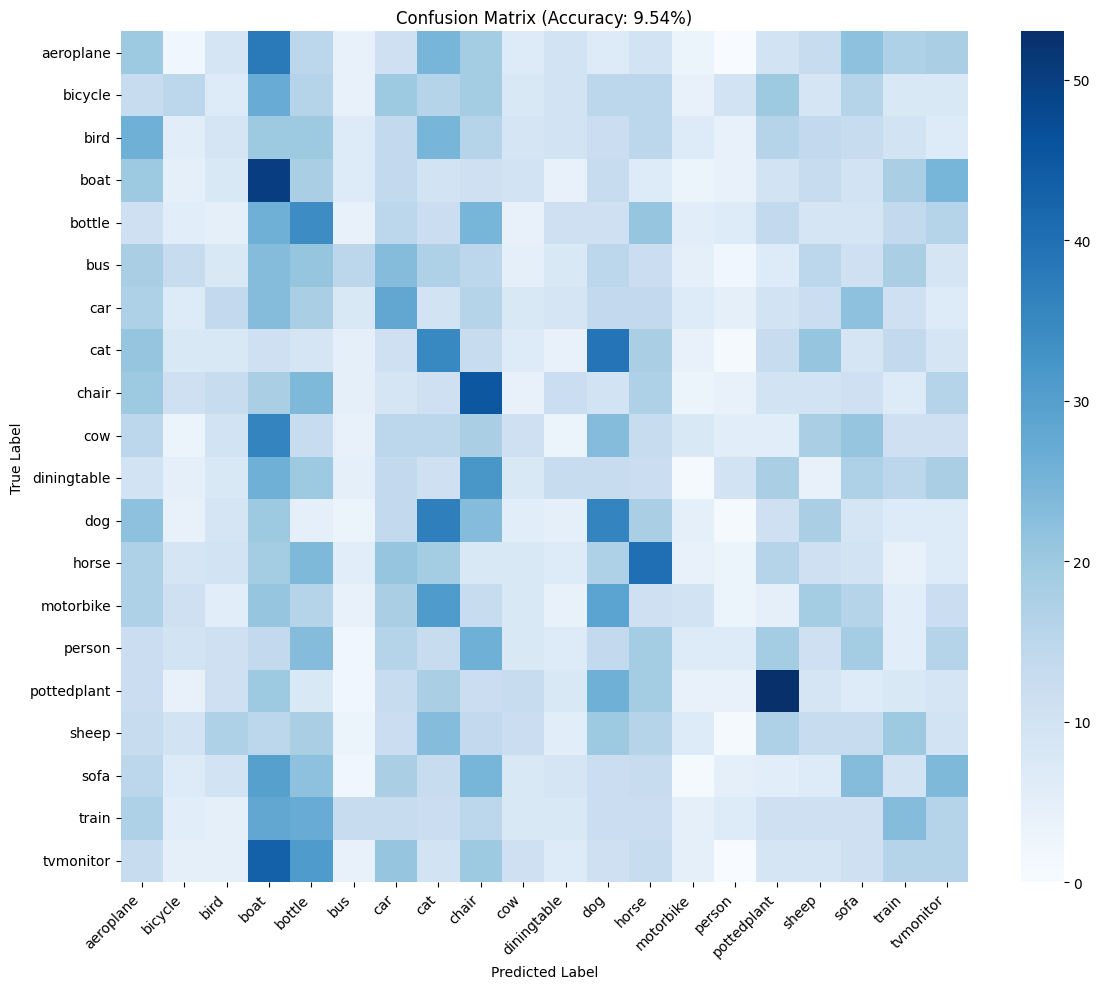

In [30]:
# ========== LOAD AND EVALUATE BEST MODEL ==========
print("\n" + "="*60)
print("LOADING BEST MODEL FOR EVALUATION")
print("="*60)

# Load best model
print("\n" + "="*60)
print("LOADING BEST MODEL")
print("="*60)

checkpoint = torch.load(f'checkpoints/best_baseline_task1.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✓ Loaded model from epoch {checkpoint['epoch']+1}")
print(f"  Validation accuracy: {checkpoint['val_acc']:.2f}%")

# Evaluate
results = evaluate_task1(model, test_loader, device)

# Save results
results_summary = {
    'model_type': MODEL_TYPE,
    'overall_accuracy': float(results['overall_acc']),
    'chance_level': 5.0,
    'above_chance': results['overall_acc'] > 5,
    'subject_accuracies': {int(k): float(v) for k, v in results['subject_accs'].items()},
    'class_accuracies': {int(k): float(v) for k, v in results['class_accs'].items()}
}

with open(f'task1_{MODEL_TYPE}_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print(f"\n✓ Results saved to: task1_{MODEL_TYPE}_results.json")

In [29]:
!pwd


/jet/home/gulavani


## Task 2A: Image-Caption Retrieval with CLIP

In [31]:
print("\n" + "="*60)
print("TASK 2A: IMAGE-CAPTION RETRIEVAL WITH CLIP")
print("="*60)

# Load pretrained CLIP
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

clip_model.eval()
for param in clip_model.parameters():
    param.requires_grad = False

print("✓ CLIP model loaded")


@torch.no_grad()
def extract_clip_embeddings(dataset, clip_model, clip_processor, clip_tokenizer, 
                            device, batch_size=32):
    """Extract CLIP embeddings for images and captions"""
    
    # Get unique images and captions
    unique_data = {}
    for item in dataset.trial_metadata:
        img_name = item['img_name']
        if img_name not in unique_data:
            unique_data[img_name] = {
                'caption': item['caption'],
                'category_label': item['category_label'],
                'img_path': item['img_path']
            }
    
    image_names = list(unique_data.keys())
    captions = [unique_data[name]['caption'] for name in image_names]
    labels = torch.tensor([unique_data[name]['category_label'] for name in image_names])
    
    print(f"Extracting embeddings for {len(image_names)} unique images...")
    
    image_embeddings = []
    text_embeddings = []
    
    for i in tqdm(range(0, len(image_names), batch_size)):
        batch_names = image_names[i:i+batch_size]
        batch_captions = captions[i:i+batch_size]
        
        # Load images
        batch_images = []
        for name in batch_names:
            try:
                img = Image.open(unique_data[name]['img_path']).convert('RGB')
                batch_images.append(img)
            except:
                batch_images.append(Image.new('RGB', (224, 224)))
        
        # Process
        image_inputs = clip_processor(images=batch_images, return_tensors="pt", padding=True)
        image_inputs = {k: v.to(device) for k, v in image_inputs.items()}
        
        text_inputs = clip_tokenizer(batch_captions, padding=True, truncation=True, 
                                    return_tensors="pt", max_length=77)
        text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
        
        # Get embeddings
        image_features = clip_model.get_image_features(**image_inputs)
        text_features = clip_model.get_text_features(**text_inputs)
        
        # Normalize
        image_features = F.normalize(image_features, p=2, dim=-1)
        text_features = F.normalize(text_features, p=2, dim=-1)
        
        image_embeddings.append(image_features.cpu())
        text_embeddings.append(text_features.cpu())
    
    image_embeddings = torch.cat(image_embeddings, dim=0)
    text_embeddings = torch.cat(text_embeddings, dim=0)
    
    return {
        'image_names': image_names,
        'captions': captions,
        'labels': labels,
        'image_embeddings': image_embeddings,
        'text_embeddings': text_embeddings
    }


def compute_recall_at_k(similarities, k_values=[1, 3, 5], class_aware=False, labels=None):
    """Compute Recall@K"""
    N = similarities.shape[0]
    
    # Move similarities to same device for sorting
    device = similarities.device
    top_k_indices = torch.argsort(similarities, dim=1, descending=True)
    
    # Ensure labels are on the same device if using class-aware
    if class_aware and labels is not None:
        labels = labels.to(device)
    
    results = {}
    for k in k_values:
        correct = 0
        
        for i in range(N):
            top_k = top_k_indices[i, :k]
            
            if class_aware and labels is not None:
                query_label = labels[i]
                retrieved_labels = labels[top_k]
                if (retrieved_labels == query_label).any():
                    correct += 1
            else:
                if i in top_k:
                    correct += 1
        
        results[f"Recall@{k}"] = 100.0 * correct / N
    
    return results


def compute_map(similarities, class_aware=False, labels=None):
    """Compute Mean Average Precision"""
    N = similarities.shape[0]
    device = similarities.device
    
    # Ensure everything is on CPU for numpy operations
    similarities_cpu = similarities.cpu() if similarities.is_cuda else similarities
    sorted_indices = torch.argsort(similarities_cpu, dim=1, descending=True)
    
    if labels is not None:
        labels_cpu = labels.cpu() if labels.is_cuda else labels
        labels_np = labels_cpu.numpy()
    
    average_precisions = []
    
    for i in range(N):
        sorted_idx = sorted_indices[i]
        
        if class_aware and labels is not None:
            query_label = labels_np[i]
            relevant_mask = (labels_np == query_label)
        else:
            relevant_mask = np.zeros(N, dtype=bool)
            relevant_mask[i] = True
        
        precisions = []
        num_relevant = 0
        
        for rank, idx in enumerate(sorted_idx, 1):
            if relevant_mask[idx]:
                num_relevant += 1
                precisions.append(num_relevant / rank)
        
        if precisions:
            average_precisions.append(np.mean(precisions))
        else:
            average_precisions.append(0.0)
    
    return np.mean(average_precisions)


def evaluate_task2a(test_dataset, clip_model, clip_processor, clip_tokenizer, device):
    """Full evaluation for Task 2A"""
    
    # Extract embeddings
    embeddings = extract_clip_embeddings(
        test_dataset, clip_model, clip_processor, clip_tokenizer, device)
    
    image_emb = embeddings['image_embeddings'].to(device)
    text_emb = embeddings['text_embeddings'].to(device)
    labels = embeddings['labels']  # Keep on CPU initially
    
    # Compute similarities
    similarities = torch.mm(image_emb, text_emb.t())
    
    print(f"\n{'='*60}")
    print(f"TASK 2A: IMAGE-CAPTION RETRIEVAL RESULTS")
    print(f"{'='*60}")
    
    # Instance-level Recall@K
    print("\n1. Instance-Level Recall@K:")
    instance_recall = compute_recall_at_k(similarities, k_values=[1, 3, 5])
    for k, v in instance_recall.items():
        print(f"   {k}: {v:.2f}%")
    
    # Class-aware Recall@K (labels will be moved to device inside function)
    print("\n2. Class-Aware Recall@K:")
    class_recall = compute_recall_at_k(similarities, k_values=[1, 3, 5], 
                                      class_aware=True, labels=labels)
    for k, v in class_recall.items():
        print(f"   {k}: {v:.2f}%")
    
    # MAP (will be computed on CPU inside function)
    print("\n3. Mean Average Precision:")
    instance_map = compute_map(similarities, labels=labels)
    print(f"   Instance-Level MAP: {instance_map:.4f}")
    
    class_map = compute_map(similarities, class_aware=True, labels=labels)
    print(f"   Class-Aware MAP: {class_map:.4f}")
    
    return {
        'instance_recall': instance_recall,
        'class_recall': class_recall,
        'instance_map': instance_map,
        'class_map': class_map,
        'embeddings': embeddings
    }


TASK 2A: IMAGE-CAPTION RETRIEVAL WITH CLIP


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


✓ CLIP model loaded


## Task 2B: EEG-Caption Retrieval

### EEG-to-CLIP Projection Head

In [ ]:
print("\n" + "="*60)
print("TASK 2B: EEG-CAPTION RETRIEVAL")
print("="*60)

class EEGToTextProjection(nn.Module):
    """Project EEG embeddings to CLIP text space"""
    def __init__(self, eeg_dim=512, clip_dim=512, use_mlp=True):
        super().__init__()
        if use_mlp:
            self.projection = nn.Sequential(
                nn.Linear(eeg_dim, clip_dim),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(clip_dim, clip_dim)
            )
        else:
            self.projection = nn.Linear(eeg_dim, clip_dim)
    
    def forward(self, x):
        x = self.projection(x)
        return F.normalize(x, p=2, dim=-1)


def train_eeg_to_clip(eeg_encoder, projection, clip_model, train_loader, val_loader,
                      device, num_epochs=20, lr=1e-4):
    """Train EEG-to-CLIP projection"""
    
    optimizer = AdamW(list(eeg_encoder.parameters()) + list(projection.parameters()), 
                     lr=lr, weight_decay=1e-5)
    
    best_val_acc = 0
    
    for epoch in range(num_epochs):
        # Train
        eeg_encoder.train()
        projection.train()
        
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            eeg = batch['eeg'].to(device)
            captions = batch['caption']
            
            # Get EEG embedding
            eeg_emb = eeg_encoder(eeg)
            eeg_proj = projection(eeg_emb)
            
            # Get text embedding from CLIP
            text_inputs = clip_tokenizer(captions, padding=True, truncation=True,
                                        return_tensors="pt", max_length=77)
            text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
            
            with torch.no_grad():
                text_features = clip_model.get_text_features(**text_inputs)
                text_features = F.normalize(text_features, p=2, dim=-1)
            
            # Cosine similarity loss
            loss = 1 - (eeg_proj * text_features).sum(dim=1).mean()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        
        # Validate
        eeg_encoder.eval()
        projection.eval()
        
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch in val_loader:
                eeg = batch['eeg'].to(device)
                captions = batch['caption']
                
                eeg_emb = eeg_encoder(eeg)
                eeg_proj = projection(eeg_emb)
                
                text_inputs = clip_tokenizer(captions, padding=True, truncation=True,
                                            return_tensors="pt", max_length=77)
                text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
                
                text_features = clip_model.get_text_features(**text_inputs)
                text_features = F.normalize(text_features, p=2, dim=-1)
                
                sims = torch.mm(eeg_proj, text_features.t())
                preds = sims.argmax(dim=1)
                correct += (preds == torch.arange(len(eeg), device=device)).sum().item()
                total += len(eeg)
        
        val_acc = 100. * correct / total
        
        print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Val Acc={val_acc:.2f}%")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'eeg_encoder': eeg_encoder.state_dict(),
                'projection': projection.state_dict()
            }, 'checkpoints/best_eeg_to_clip.pth')
    
    return best_val_acc


def evaluate_task2b(eeg_encoder, projection, test_dataset, clip_model, 
                   clip_tokenizer, device):
    """Evaluate EEG-Caption retrieval"""
    
    eeg_encoder.eval()
    projection.eval()
    
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    all_eeg_embs = []
    all_captions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Extracting EEG embeddings"):
            eeg = batch['eeg'].to(device)
            
            eeg_emb = eeg_encoder(eeg)
            eeg_proj = projection(eeg_emb)
            
            all_eeg_embs.append(eeg_proj.cpu())
            all_captions.extend(batch['caption'])
            all_labels.extend(batch['label'].numpy())
    
    all_eeg_embs = torch.cat(all_eeg_embs, dim=0).to(device)
    all_labels = torch.tensor(all_labels)
    
    # Get text embeddings
    all_text_embs = []
    for i in range(0, len(all_captions), 32):
        batch_captions = all_captions[i:i+32]
        text_inputs = clip_tokenizer(batch_captions, padding=True, truncation=True,
                                    return_tensors="pt", max_length=77)
        text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
        
        with torch.no_grad():
            text_features = clip_model.get_text_features(**text_inputs)
            text_features = F.normalize(text_features, p=2, dim=-1)
            all_text_embs.append(text_features.cpu())
    
    all_text_embs = torch.cat(all_text_embs, dim=0).to(device)
    
    # Compute similarities
    similarities = torch.mm(all_eeg_embs, all_text_embs.t())
    
    print(f"\n{'='*60}")
    print(f"TASK 2B: EEG-CAPTION RETRIEVAL RESULTS")
    print(f"{'='*60}")
    
    # Recall@K
    print("\n1. Instance-Level Recall@K:")
    instance_recall = compute_recall_at_k(similarities, k_values=[1, 3, 5])
    for k, v in instance_recall.items():
        print(f"   {k}: {v:.2f}%")
    
    print("\n2. Class-Aware Recall@K:")
    class_recall = compute_recall_at_k(similarities, k_values=[1, 3, 5],
                                      class_aware=True, labels=all_labels)
    for k, v in class_recall.items():
        print(f"   {k}: {v:.2f}%")
    
    # MAP
    print("\n3. Mean Average Precision:")
    instance_map = compute_map(similarities.cpu())
    print(f"   Instance-Level MAP: {instance_map:.4f}")
    
    class_map = compute_map(similarities.cpu(), class_aware=True, labels=all_labels)
    print(f"   Class-Aware MAP: {class_map:.4f}")
    
    return {
        'instance_recall': instance_recall,
        'class_recall': class_recall,
        'instance_map': instance_map,
        'class_map': class_map
    }


TASK 2B: EEG-CAPTION RETRIEVAL


In [34]:
print("\n" + "="*60)
print("ADVANCED CLIP FINE-TUNING WITH LoRA")
print("="*60)

def apply_lora_to_clip(clip_model, r=8, lora_alpha=16, lora_dropout=0.1):
    """Apply LoRA to CLIP text encoder"""
    
    # Configure LoRA for text encoder only
    lora_config = LoraConfig(
        r=r,
        lora_alpha=lora_alpha,
        target_modules=["q_proj", "v_proj"],  # Apply to attention layers
        lora_dropout=lora_dropout,
        bias="none",
        modules_to_save=["text_projection"]  # Also train text projection
    )
    
    # Apply LoRA
    clip_model.text_model = get_peft_model(clip_model.text_model, lora_config)
    
    # Count trainable parameters
    trainable_params = sum(p.numel() for p in clip_model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in clip_model.parameters())
    
    print(f"LoRA applied: {trainable_params:,} / {total_params:,} parameters trainable")
    print(f"Trainable percentage: {100 * trainable_params / total_params:.2f}%")
    
    return clip_model


def train_eeg_to_clip_with_lora(eeg_encoder, projection, clip_model, 
                                train_loader, val_loader, device,
                                use_lora=True, use_kd=True, use_contrastive=True,
                                num_epochs=20, lr=1e-4):
    """
    Advanced training with multiple loss strategies
    """
    
    # Apply LoRA if requested
    if use_lora:
        clip_model = apply_lora_to_clip(clip_model)
    
    # Setup optimizer
    params = list(eeg_encoder.parameters()) + list(projection.parameters())
    if use_lora:
        params += list(clip_model.text_model.parameters())
    
    optimizer = AdamW(params, lr=lr, weight_decay=1e-5)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    best_val_recall = 0
    
    for epoch in range(num_epochs):
        # Training phase
        eeg_encoder.train()
        projection.train()
        if use_lora:
            clip_model.text_model.train()
        
        total_loss = 0
        loss_components = {'cos': 0, 'kd': 0, 'contrastive': 0}
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            eeg = batch['eeg'].to(device)
            captions = batch['caption']
            labels = batch['label'].to(device)
            
            # Get EEG embeddings
            eeg_emb = eeg_encoder(eeg)
            eeg_proj = projection(eeg_emb)
            eeg_proj = F.normalize(eeg_proj, p=2, dim=-1)
            
            # Get text embeddings
            text_inputs = clip_tokenizer(captions, padding=True, truncation=True,
                                        return_tensors="pt", max_length=77)
            text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
            
            text_features = clip_model.get_text_features(**text_inputs)
            text_features = F.normalize(text_features, p=2, dim=-1)
            
            loss = 0
            
            # 1. Cosine similarity loss (Knowledge Distillation)
            if use_kd:
                loss_cos = 1 - (eeg_proj * text_features).sum(dim=1).mean()
                loss += 0.5 * loss_cos
                loss_components['cos'] += loss_cos.item()
            
            # 2. Contrastive loss with class-aware negatives
            if use_contrastive:
                batch_size = eeg_proj.shape[0]
                
                # Compute similarity matrix
                logits = torch.matmul(eeg_proj, text_features.t()) / 0.07  # temperature
                
                # Create class-aware weights for negatives
                label_matrix = labels.unsqueeze(1) == labels.unsqueeze(0)
                weights = torch.ones_like(logits)
                weights[label_matrix] = 0.3  # Down-weight same-class negatives
                weights.fill_diagonal_(1.0)  # Keep diagonal (positive pairs) at 1.0
                
                # Weighted contrastive loss
                exp_logits = torch.exp(logits) * weights
                log_prob = logits - torch.log(exp_logits.sum(dim=1, keepdim=True))
                loss_contrast = -log_prob.diagonal().mean()
                
                loss += 0.5 * loss_contrast
                loss_components['contrastive'] += loss_contrast.item()
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(params, max_norm=1.0)
            optimizer.step()
            
            total_loss += loss.item()
        
        scheduler.step()
        
        # Print epoch statistics
        avg_loss = total_loss / len(train_loader)
        print(f"\nEpoch {epoch+1} Training:")
        print(f"  Total Loss: {avg_loss:.4f}")
        if use_kd:
            print(f"  Cosine Loss: {loss_components['cos']/len(train_loader):.4f}")
        if use_contrastive:
            print(f"  Contrastive Loss: {loss_components['contrastive']/len(train_loader):.4f}")
        
        # Validation phase
        eeg_encoder.eval()
        projection.eval()
        if use_lora:
            clip_model.text_model.eval()
        
        val_recall = 0
        val_samples = 0
        
        with torch.no_grad():
            for batch in val_loader:
                eeg = batch['eeg'].to(device)
                captions = batch['caption']
                
                eeg_emb = eeg_encoder(eeg)
                eeg_proj = projection(eeg_emb)
                eeg_proj = F.normalize(eeg_proj, p=2, dim=-1)
                
                text_inputs = clip_tokenizer(captions, padding=True, truncation=True,
                                            return_tensors="pt", max_length=77)
                text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
                
                text_features = clip_model.get_text_features(**text_inputs)
                text_features = F.normalize(text_features, p=2, dim=-1)
                
                # Compute Recall@5
                sims = torch.mm(eeg_proj, text_features.t())
                top5 = torch.argsort(sims, dim=1, descending=True)[:, :5]
                correct = (top5 == torch.arange(len(eeg), device=device).unsqueeze(1)).any(dim=1)
                
                val_recall += correct.sum().item()
                val_samples += len(eeg)
        
        val_recall = 100.0 * val_recall / val_samples
        print(f"  Val Recall@5: {val_recall:.2f}%")
        
        # Save best model
        if val_recall > best_val_recall:
            best_val_recall = val_recall
            checkpoint = {
                'eeg_encoder': eeg_encoder.state_dict(),
                'projection': projection.state_dict(),
                'epoch': epoch,
                'val_recall': val_recall
            }
            if use_lora:
                checkpoint['clip_text_model'] = clip_model.text_model.state_dict()
            
            os.makedirs('checkpoints', exist_ok=True)
            torch.save(checkpoint, 'checkpoints/best_eeg_clip_lora.pth')
            print(f"  ✓ New best model saved!")
    
    print(f"\nTraining complete. Best Val Recall@5: {best_val_recall:.2f}%")
    return best_val_recall


ADVANCED CLIP FINE-TUNING WITH LoRA


In [ ]:
# ============================================================================
# SECTION 6: TASK 2 - IMAGE-CAPTION AND EEG-CAPTION RETRIEVAL
# ============================================================================

# Note: train_loader, val_loader, test_loader, device already created above

# Load CLIP model
print("\n" + "="*60)
print("LOADING CLIP MODEL FOR TASK 2")
print("="*60)

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

print("✓ CLIP model loaded")

# --------------------------------------------------------------------------
# TASK 2A: IMAGE-CAPTION RETRIEVAL
# --------------------------------------------------------------------------

print("\n" + "="*60)
print("STARTING TASK 2A: IMAGE-CAPTION RETRIEVAL")
print("="*60)

# Task 2A: Evaluate CLIP on image-caption retrieval
task2a_results = evaluate_task2a(test_dataset, clip_model, clip_processor, 
                                  clip_tokenizer, device)

# --------------------------------------------------------------------------
# TASK 2B: EEG-CAPTION RETRIEVAL
# --------------------------------------------------------------------------

print("\n" + "="*60)
print("STARTING TASK 2B: EEG-CAPTION RETRIEVAL")
print("="*60)

# Initialize models for Task 2B
# Specify which Task 1 model to use
TASK1_MODEL_TYPE = "baseline"  # Options: "baseline", "cnn", "multihead"
TASK1_RUN_ID = "your-run-id-here"  # ⚠️ UPDATE THIS from wandb!

# Load the trained encoder
eeg_encoder, encoder_dim = load_task1_encoder(
    model_type=TASK1_MODEL_TYPE,
    task1_run_id=TASK1_RUN_ID,
    device=device
)

# Freeze encoder initially (optional - you can unfreeze for fine-tuning)
for param in eeg_encoder.parameters():
    param.requires_grad = True  # Set to False to freeze

# Create projection head with correct dimension
projection = EEGToTextProjection(
    eeg_dim=encoder_dim,  # Automatically matched!
    clip_dim=512,
    use_mlp=True
).to(device)

# Train with LoRA
print("\nTraining with LoRA fine-tuning...")
best_val = train_eeg_to_clip_with_lora(
    eeg_encoder, projection, clip_model,
    train_loader, val_loader, device,
    use_lora=True,
    use_kd=True,
    use_contrastive=True,
    num_epochs=20,
    lr=1e-4
)

# Load best checkpoint and evaluate
print("\nLoading best checkpoint for final evaluation...")
checkpoint = torch.load('checkpoints/best_eeg_clip_lora.pth')
eeg_encoder.load_state_dict(checkpoint['eeg_encoder'])
projection.load_state_dict(checkpoint['projection'])

# Final evaluation on test set
print("\n" + "="*60)
print("FINAL EVALUATION ON TEST SET")
print("="*60)

task2b_results = evaluate_task2b(eeg_encoder, projection, test_dataset,
                                  clip_model, clip_tokenizer, device)

# --------------------------------------------------------------------------
# FINAL SUMMARY
# --------------------------------------------------------------------------

print("\n" + "="*60)
print("ALL TASKS COMPLETE!")
print("="*60)
print(f"\nTask 2A (Image-Caption) Recall@5: {task2a_results['instance_recall']['Recall@5']:.2f}%")
print(f"Task 2B (EEG-Caption) Recall@5: {task2b_results['instance_recall']['Recall@5']:.2f}%")


LOADING CLIP MODEL FOR TASK 2
✓ CLIP model loaded

STARTING TASK 2A: IMAGE-CAPTION RETRIEVAL
Extracting embeddings for 4046 unique images...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:35<00:00,  3.62it/s]



TASK 2A: IMAGE-CAPTION RETRIEVAL RESULTS

1. Instance-Level Recall@K:
   Recall@1: 27.63%
   Recall@3: 44.86%
   Recall@5: 53.51%

2. Class-Aware Recall@K:
   Recall@1: 96.69%
   Recall@3: 98.10%
   Recall@5: 98.64%

3. Mean Average Precision:
   Instance-Level MAP: 0.3994
   Class-Aware MAP: 0.8308

STARTING TASK 2B: EEG-CAPTION RETRIEVAL

Training with LoRA fine-tuning...
LoRA applied: 88,307,969 / 151,473,921 parameters trainable
Trainable percentage: 58.30%


Epoch 1/20: 100%|███████████████████████████████████████████████████████████████████████████████████| 488/488 [00:54<00:00,  9.02it/s]


Epoch 1 Training:
  Total Loss: 1.7932
  Cosine Loss: 0.1502
  Contrastive Loss: 3.4362


  Val Recall@5: 16.48%
  ✓ New best model saved!


Epoch 2/20: 100%|███████████████████████████████████████████████████████████████████████████████████| 488/488 [00:54<00:00,  8.96it/s]


Epoch 2 Training:
  Total Loss: 1.7214
  Cosine Loss: 0.0134
  Contrastive Loss: 3.4293


  Val Recall@5: 16.94%
  ✓ New best model saved!


Epoch 3/20: 100%|███████████████████████████████████████████████████████████████████████████████████| 488/488 [00:54<00:00,  8.96it/s]


Epoch 3 Training:
  Total Loss: 1.7180
  Cosine Loss: 0.0072
  Contrastive Loss: 3.4288


  Val Recall@5: 17.92%
  ✓ New best model saved!


Epoch 4/20: 100%|███████████████████████████████████████████████████████████████████████████████████| 488/488 [00:54<00:00,  8.94it/s]


Epoch 4 Training:
  Total Loss: 1.7170
  Cosine Loss: 0.0048
  Contrastive Loss: 3.4292


  Val Recall@5: 18.15%
  ✓ New best model saved!


Epoch 5/20: 100%|███████████████████████████████████████████████████████████████████████████████████| 488/488 [00:54<00:00,  9.00it/s]


Epoch 5 Training:
  Total Loss: 1.7154
  Cosine Loss: 0.0059
  Contrastive Loss: 3.4250


  Val Recall@5: 17.92%


Epoch 6/20: 100%|███████████████████████████████████████████████████████████████████████████████████| 488/488 [00:54<00:00,  9.00it/s]


Epoch 6 Training:
  Total Loss: 1.7102
  Cosine Loss: 0.0129
  Contrastive Loss: 3.4076


  Val Recall@5: 19.67%
  ✓ New best model saved!


Epoch 7/20: 100%|███████████████████████████████████████████████████████████████████████████████████| 488/488 [00:54<00:00,  9.00it/s]


Epoch 7 Training:
  Total Loss: 1.7023
  Cosine Loss: 0.0167
  Contrastive Loss: 3.3880


  Val Recall@5: 20.17%
  ✓ New best model saved!


Epoch 8/20: 100%|███████████████████████████████████████████████████████████████████████████████████| 488/488 [00:53<00:00,  9.06it/s]


Epoch 8 Training:
  Total Loss: 1.6934
  Cosine Loss: 0.0190
  Contrastive Loss: 3.3679


  Val Recall@5: 20.25%
  ✓ New best model saved!


Epoch 9/20: 100%|███████████████████████████████████████████████████████████████████████████████████| 488/488 [00:53<00:00,  9.09it/s]


Epoch 9 Training:
  Total Loss: 1.6834
  Cosine Loss: 0.0222
  Contrastive Loss: 3.3445


  Val Recall@5: 21.73%
  ✓ New best model saved!


Epoch 10/20: 100%|██████████████████████████████████████████████████████████████████████████████████| 488/488 [00:53<00:00,  9.10it/s]


Epoch 10 Training:
  Total Loss: 1.6714
  Cosine Loss: 0.0284
  Contrastive Loss: 3.3144


  Val Recall@5: 21.60%


Epoch 11/20: 100%|██████████████████████████████████████████████████████████████████████████████████| 488/488 [00:53<00:00,  9.05it/s]


Epoch 11 Training:
  Total Loss: 1.6553
  Cosine Loss: 0.0352
  Contrastive Loss: 3.2754


  Val Recall@5: 21.65%


Epoch 12/20: 100%|██████████████████████████████████████████████████████████████████████████████████| 488/488 [00:53<00:00,  9.17it/s]


Epoch 12 Training:
  Total Loss: 1.6397
  Cosine Loss: 0.0391
  Contrastive Loss: 3.2402


  Val Recall@5: 22.19%
  ✓ New best model saved!


Epoch 13/20: 100%|██████████████████████████████████████████████████████████████████████████████████| 488/488 [00:53<00:00,  9.07it/s]


Epoch 13 Training:
  Total Loss: 1.6187
  Cosine Loss: 0.0426
  Contrastive Loss: 3.1948


  Val Recall@5: 22.67%
  ✓ New best model saved!


Epoch 14/20: 100%|██████████████████████████████████████████████████████████████████████████████████| 488/488 [00:53<00:00,  9.16it/s]


Epoch 14 Training:
  Total Loss: 1.6043
  Cosine Loss: 0.0460
  Contrastive Loss: 3.1626


  Val Recall@5: 22.42%


Epoch 15/20: 100%|██████████████████████████████████████████████████████████████████████████████████| 488/488 [00:53<00:00,  9.13it/s]


Epoch 15 Training:
  Total Loss: 1.5849
  Cosine Loss: 0.0488
  Contrastive Loss: 3.1209


  Val Recall@5: 22.42%


Epoch 16/20: 100%|██████████████████████████████████████████████████████████████████████████████████| 488/488 [00:53<00:00,  9.09it/s]


Epoch 16 Training:
  Total Loss: 1.5736
  Cosine Loss: 0.0507
  Contrastive Loss: 3.0965


  Val Recall@5: 21.67%


Epoch 17/20: 100%|██████████████████████████████████████████████████████████████████████████████████| 488/488 [00:53<00:00,  9.15it/s]


Epoch 17 Training:
  Total Loss: 1.5610
  Cosine Loss: 0.0512
  Contrastive Loss: 3.0707


  Val Recall@5: 21.94%


Epoch 18/20: 100%|██████████████████████████████████████████████████████████████████████████████████| 488/488 [00:53<00:00,  9.04it/s]


Epoch 18 Training:
  Total Loss: 1.5524
  Cosine Loss: 0.0523
  Contrastive Loss: 3.0526


  Val Recall@5: 22.25%


Epoch 19/20: 100%|██████████████████████████████████████████████████████████████████████████████████| 488/488 [00:53<00:00,  9.07it/s]


Epoch 19 Training:
  Total Loss: 1.5471
  Cosine Loss: 0.0531
  Contrastive Loss: 3.0412


  Val Recall@5: 22.13%


Epoch 20/20: 100%|██████████████████████████████████████████████████████████████████████████████████| 488/488 [00:53<00:00,  9.09it/s]


Epoch 20 Training:
  Total Loss: 1.5426
  Cosine Loss: 0.0531
  Contrastive Loss: 3.0321


  Val Recall@5: 21.92%

Training complete. Best Val Recall@5: 22.67%

Loading best checkpoint for final evaluation...

FINAL EVALUATION ON TEST SET


Extracting EEG embeddings: 100%|████████████████████████████████████████████████████████████████████| 163/163 [01:04<00:00,  2.53it/s]



TASK 2B: EEG-CAPTION RETRIEVAL RESULTS

1. Instance-Level Recall@K:
   Recall@1: 0.00%
   Recall@3: 0.02%
   Recall@5: 0.04%

2. Class-Aware Recall@K:
   Recall@1: 7.00%
   Recall@3: 10.83%
   Recall@5: 13.63%

3. Mean Average Precision:
   Instance-Level MAP: 0.0019
   Class-Aware MAP: 0.1122

ALL TASKS COMPLETE!

Task 2A (Image-Caption) Recall@5: 53.51%
Task 2B (EEG-Caption) Recall@5: 0.04%


Saved visualization to 'viz/retrieval_examples_baseline.png'


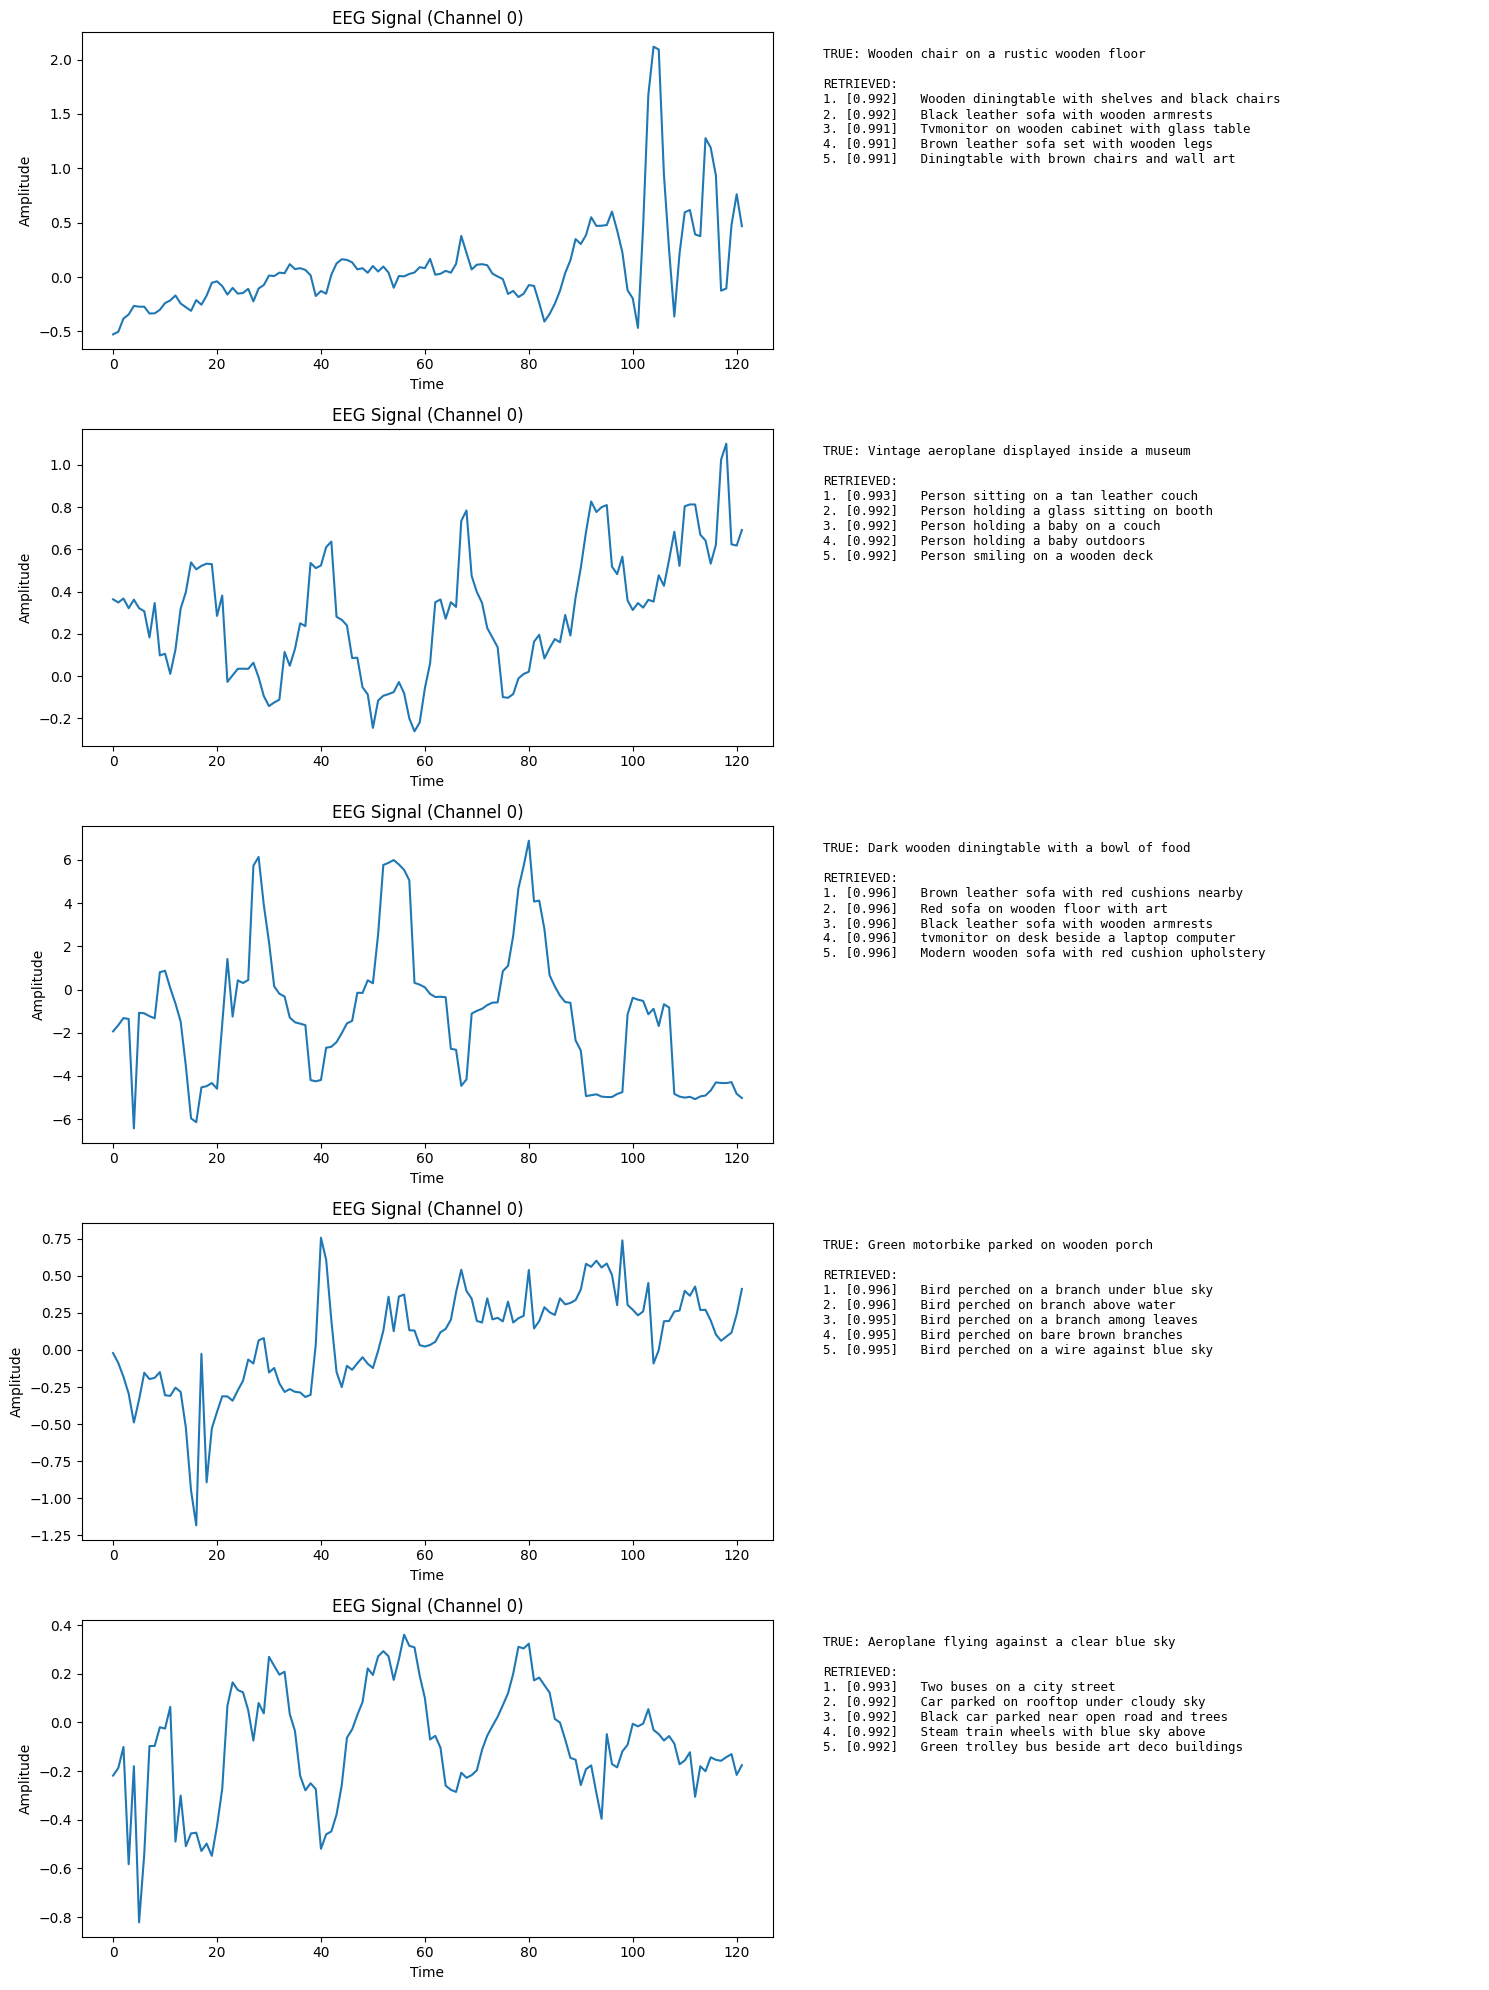

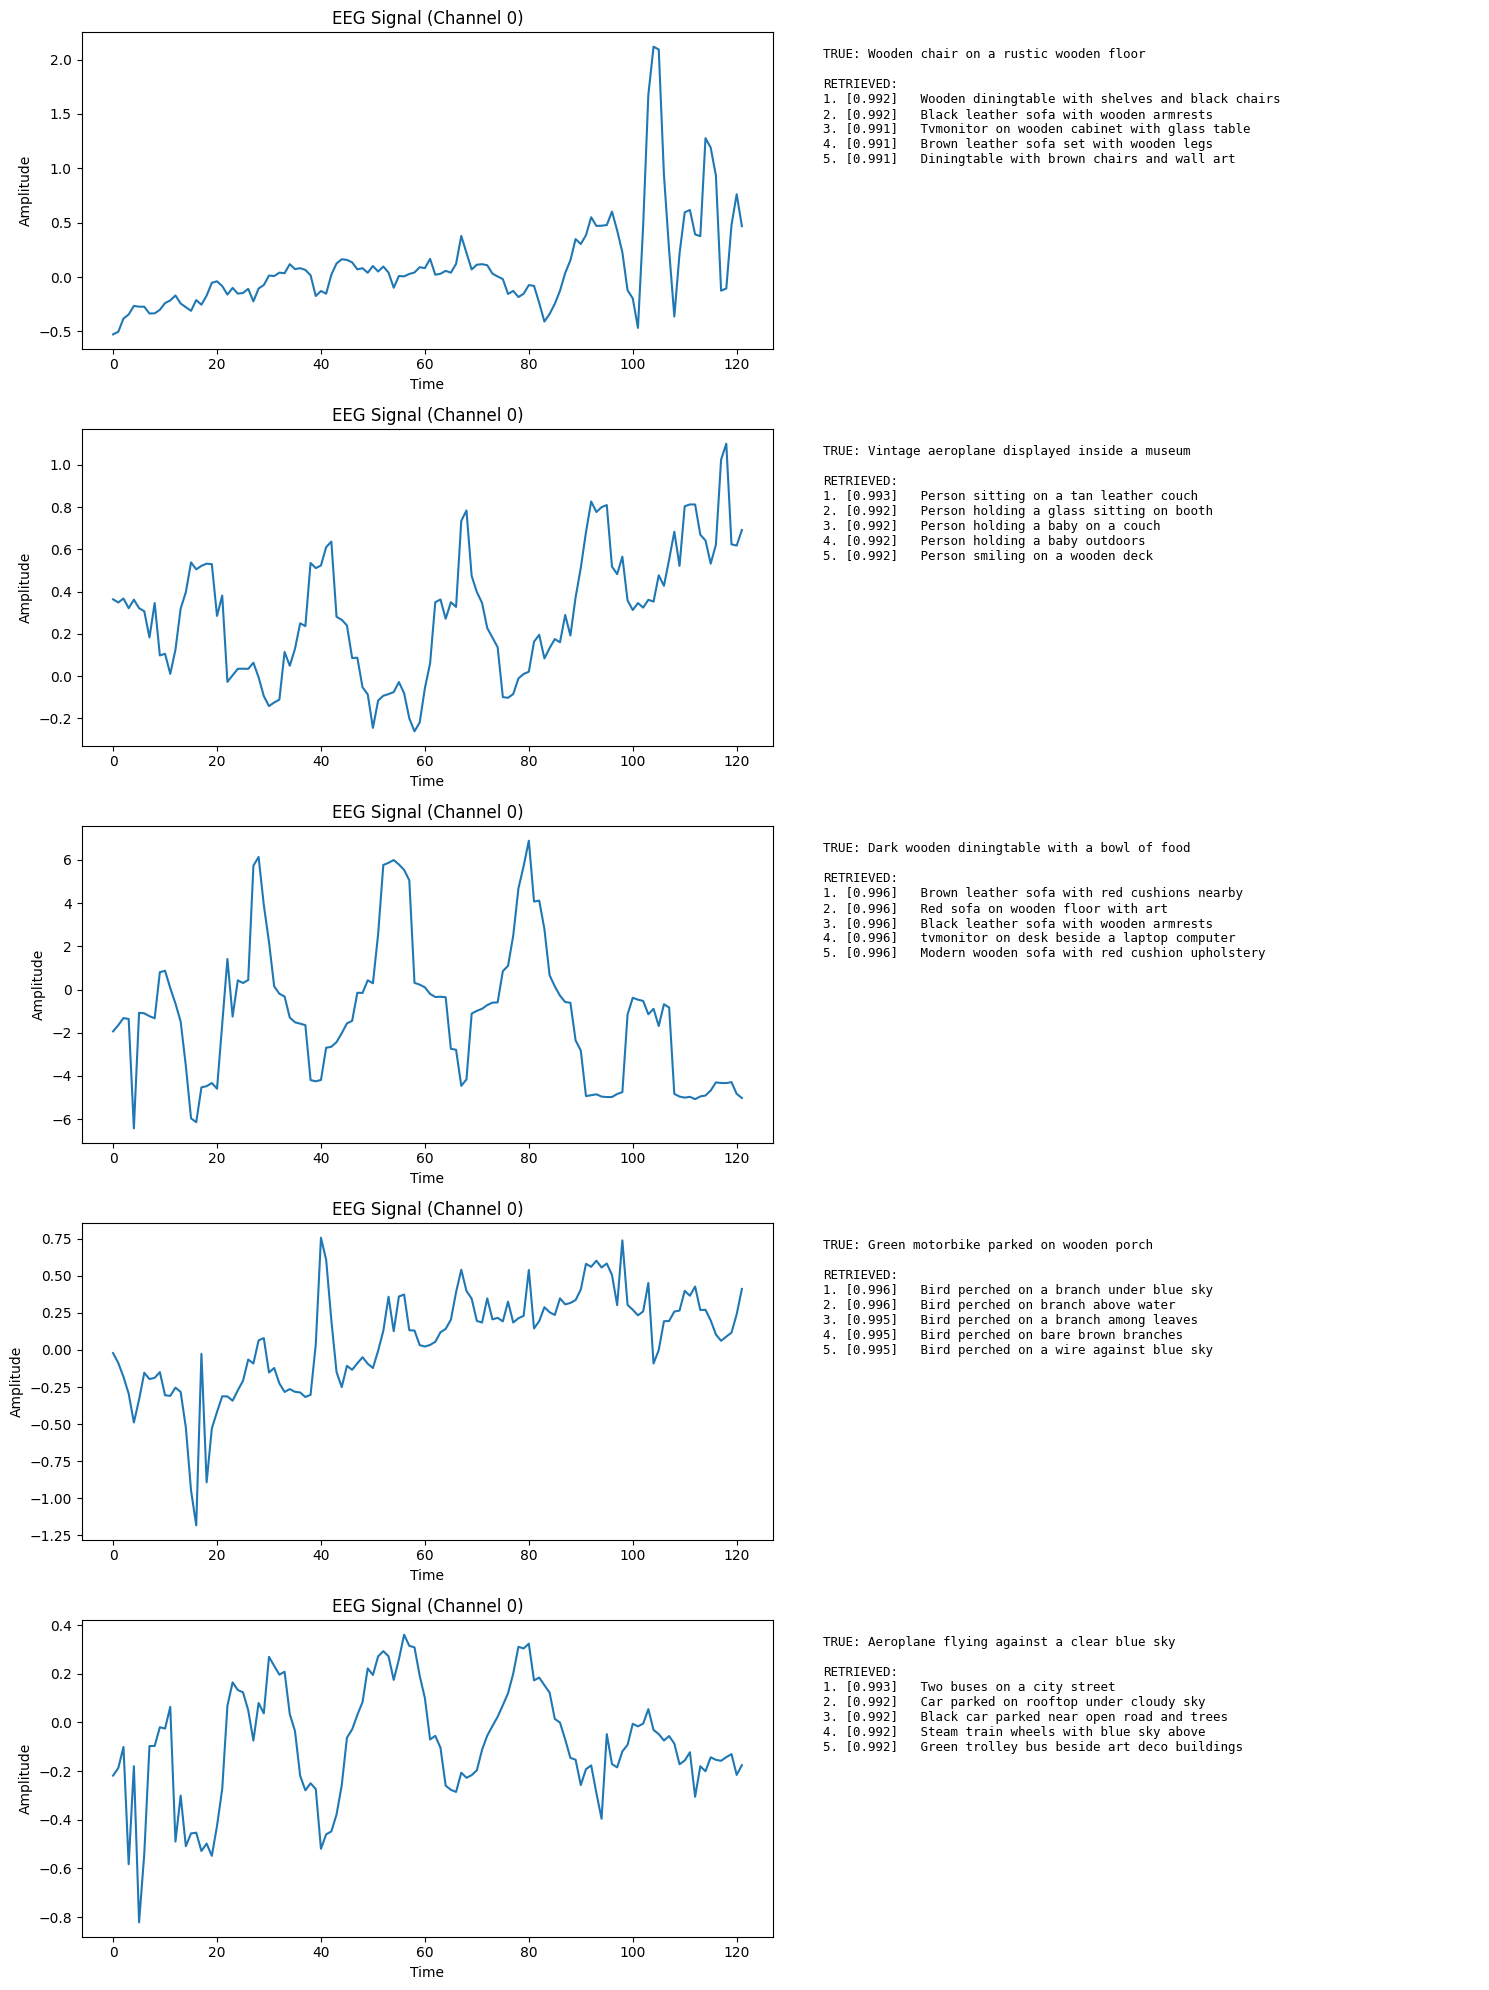

In [36]:
# ============================================================================
# SECTION 7: VISUALIZATION AND ANALYSIS
# ============================================================================

def visualize_retrieval_examples(eeg_encoder, projection, test_dataset, 
                                 clip_model, clip_tokenizer, device, num_examples=5):
    """Visualize retrieval examples"""
    
    eeg_encoder.eval()
    projection.eval()
    
    # Sample random test examples
    indices = np.random.choice(len(test_dataset), num_examples, replace=False)
    
    fig, axes = plt.subplots(num_examples, 2, figsize=(15, 4*num_examples))
    
    for idx, test_idx in enumerate(indices):
        sample = test_dataset[test_idx]
        eeg = sample['eeg'].unsqueeze(0).to(device)
        true_caption = sample['caption']
        
        # Get EEG embedding
        with torch.no_grad():
            eeg_emb = eeg_encoder(eeg)
            eeg_proj = projection(eeg_emb)
            eeg_proj = F.normalize(eeg_proj, p=2, dim=-1)
        
        # Get all captions from test set
        all_captions = [test_dataset[i]['caption'] for i in range(min(500, len(test_dataset)))]
        
        # Compute similarities
        text_inputs = clip_tokenizer(all_captions, padding=True, truncation=True,
                                    return_tensors="pt", max_length=77)
        text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
        
        with torch.no_grad():
            text_features = clip_model.get_text_features(**text_inputs)
            text_features = F.normalize(text_features, p=2, dim=-1)
            
            sims = torch.mm(eeg_proj, text_features.t()).squeeze()
            top5_indices = torch.argsort(sims, descending=True)[:5]
        
        # Plot EEG signal
        axes[idx, 0].plot(eeg.cpu().squeeze()[0, :200])  # Plot first channel
        axes[idx, 0].set_title(f"EEG Signal (Channel 0)")
        axes[idx, 0].set_xlabel("Time")
        axes[idx, 0].set_ylabel("Amplitude")
        
        # Show retrieved captions
        axes[idx, 1].axis('off')
        text_content = f"TRUE: {true_caption}\n\nRETRIEVED:\n"
        for rank, ret_idx in enumerate(top5_indices, 1):
            retrieved = all_captions[ret_idx.item()]
            score = sims[ret_idx].item()
            marker = "✓" if retrieved == true_caption else " "
            text_content += f"{rank}. [{score:.3f}] {marker} {retrieved}\n"
        
        axes[idx, 1].text(0.05, 0.95, text_content, transform=axes[idx, 1].transAxes,
                         fontsize=9, verticalalignment='top', family='monospace')
    
    plt.tight_layout()
    plt.savefig(f'viz/retrieval_examples_{MODEL_TYPE}.png', dpi=150, bbox_inches='tight')
    print(f"Saved visualization to 'viz/retrieval_examples_{MODEL_TYPE}.png'")
    
    return fig

# Call visualization after training
visualize_retrieval_examples(eeg_encoder, projection, test_dataset, 
                             clip_model, clip_tokenizer, device)

## Summary and Next Steps

### What's Implemented

This notebook includes:

1. **Complete data loading pipeline** for EEG-Image-Caption triplets
2. **Task 1**: Multi-head EEG classification with CNN+Transformer architecture
3. **Task 2A**: Image-Caption retrieval using pretrained CLIP with comprehensive metrics
4. **Task 2B Foundation**: Architecture and loss functions for EEG-Caption retrieval

### To Complete Final Submission

**Task 2B Training** (implement these based on the patterns from Task 1):

1. **Strategy 1: Frozen CLIP**
   - Train only EEG encoder + projection
   - CLIP text encoder remains frozen

2. **Strategy 2: Partial Unfreezing**
   - Unfreeze last 1-2 layers of CLIP text encoder
   - Train EEG encoder + projection + CLIP layers

3. **Strategy 3: LoRA Fine-tuning**
   - Apply LoRA to CLIP text encoder
   - Train EEG encoder + projection + LoRA adapters

**Evaluation**:
- Extract EEG embeddings for test set
- Compute all retrieval metrics (Recall@K, MAP, BERTScore, CLIPScore)
- Compare across strategies
- Create visualizations

### Files Generated

This notebook will create:
- `best_classification_model.pt` - Best Task 1 model
- `task1_training_curves.png` - Training/validation curves
- `task1_confusion_matrix.png` - Test set confusion matrix
- `task2a_clipscore_distribution.png` - CLIPScore analysis
- Additional files for Task 2B experiments

---

**Important Notes:**
1. Update `DATA_ROOT` path at the beginning
2. Training Task 1 may take several hours on GPU
3. Adjust batch sizes if running into memory issues
4. Consider using Weights & Biases for experiment tracking
5. Save intermediate results frequently